In [1]:
import numpy as np
import snanapytools as snt
import os
from collections import defaultdict
from scipy.stats import norm, truncnorm, expon
import glob
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.constants import c 
__C_LIGHT_KMS__ = c.to('km/s').value
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
import os
plt.style.use([
    'seaborn-v0_8-deep', 
     os.environ['HOME'] + '/.matplotlib_style/paper.mplstyle'
])

import scipy.stats as scs
from pathlib import Path
import sys
sys.path.append('/global/homes/b/bastienc/')
sys.path.append('../scripts/')
import my_utils as mut
import paper_fun as pf
import flip

TRIPP_KEYS = ['alpha', 'beta', 'M_0', 'sigma_M', 'gamma']
models = [
    'P21', 
    'P21_NO_DUST', 'P21_FIXED_BETA', 'P21_FIXED_BETA_NO_DUST',
    'P21_REDUCED_TAU1', 'P21_REDUCED_TAU2','P21_REDUCED_TAU4', 'P21_REDUCED_TAU3',
    'P21_REDUCED_BETA1', 'P21_REDUCED_BETA2', 'P21_REDUCED_BETA3',
    'P21_REDUCED_TAU_BETA1', 'P21_REDUCED_TAU_BETA2', 'P21_REDUCED_TAU_BETA3'
]
PIPPIN_DIR = Path(os.environ['PIPPIN_OUTPUT'])

[ 000000.00 ]: 09-11 07:27  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.00 ]: 09-11 07:27  root            INFO     Jax is not available, loading numpy and scipy instead


In [2]:
def beta_tau_modif(input_file, output_file, tau_scale=None, beta_scale=None):
    _format_dic = {
    'EBV': {'ZTRUE': '.2f', 'LOGMASS': '.2f'}, 
    'MAG_OFFSET': '.2f',
    'GENPEAK_SALT2BETA': '.8f',
    'GENSIGMA_SALT2BETA': '.8f'
    }

    if tau_scale is None and beta_scale is None:
        return
        
    par, doc = snt.tools.read_wgtmap(input_file)
    new_par = copy.deepcopy(par)
    if tau_scale is not None:
        prob = np.zeros(len(new_par['EBV']['EBV']))
        if tau_scale == 0:
            mask = new_par['EBV']['EBV'] == 0
            prob[mask] = 1
        else:
            mass_mask = new_par['EBV']['LOGMASS'] < 10

            plowM = scs.expon.pdf(new_par['EBV']['EBV'][mass_mask], scale=tau_scale * tau_lowM)
            plowM /= plowM.max()
            
            phighM = scs.expon.pdf(new_par['EBV']['EBV'][mass_mask], scale=tau_scale * tau_highM)
            phighM /= phighM.max()
            
            prob[mass_mask] = plowM
            prob[~mass_mask] = phighM
            
        new_par['EBV'].loc[:, 'PROB'] = prob 
    
    if beta_scale is not None:
        new_par['GENSIGMA_SALT2BETA'] = [beta_scale * new_par['GENSIGMA_SALT2BETA'][0], beta_scale * new_par['GENSIGMA_SALT2BETA'][1]]

    snt.tools.write_wgtmap(output_file,
                           new_par, docstr=doc, format_dic=format_dic)
      
    
        

In [ ]:
file_origin = os.environ['SNDATA_ROOT'] + '/models/population_pdf/DES-SN5YR/DES-SN5YR_LOWZ_S3_P21.DAT.gz'

# VARIATION OF DIST
path = '/global/homes/b/bastienc/MY_SNANA_DIR/LSST_SNANA/DESCPub00196/pippin_files/snana_input/P23_variations/'
par, doc = snt.tools.read_wgtmap(file_origin)
tau_lowM = 0.12
tau_highM = 0.15
format_dic = {
    'EBV': {'ZTRUE': '.2f', 'LOGMASS': '.2f'}, 
    'MAG_OFFSET': '.2f',
    'GENPEAK_SALT2BETA': '.8f',
    'GENSIGMA_SALT2BETA': '.8f'
    }

# NO DUST SET EBV = 0
beta_tau_modif(file_origin, 
               path  + "DES-SN5YR_LOWZ_S3_P21_NO_DUST.DAT", 
               tau_scale=0, beta_scale=None)

# BETA FIXED 
beta_tau_modif(file_origin, 
               path  + "DES-SN5YR_LOWZ_S3_P21_FIXED_BETA.DAT", 
               tau_scale=None, beta_scale=0)

# BETA FIXED + NO DUST
beta_tau_modif(file_origin, 
               path  + "DES-SN5YR_LOWZ_S3_P21_FIXED_BETA_NO_DUST.DAT", 
               tau_scale=0, beta_scale=0)

# REDUCED TAU
for s in [0.05, 0.25, 0.5, 0.75]:
    beta_tau_modif(file_origin, 
                   path  + f"DES-SN5YR_LOWZ_S3_P21_REDUCED_TAU_{int(s)}_{int((s - int(s)) * 100):02d}.DAT", 
                   tau_scale=s, beta_scale=None)
# REDUCED BETA
for s in [0.05, 0.25, 0.75]:
    beta_tau_modif(file_origin, 
                   path  + f"DES-SN5YR_LOWZ_S3_P21_REDUCED_BETA_{int(s)}_{int((s - int(s)) * 100):02d}.DAT", 
                   tau_scale=None, beta_scale=s)

# REDUCED TAU & BETA
for s in [0.05, 0.25, 0.75]:
    beta_tau_modif(file_origin, 
                   path  + f"DES-SN5YR_LOWZ_S3_P21_REDUCED_TAU_BETA_{int(s)}_{int((s - int(s)) * 100):02d}.DAT", 
                   tau_scale=s, beta_scale=s)

NameError: name 'model' is not defined

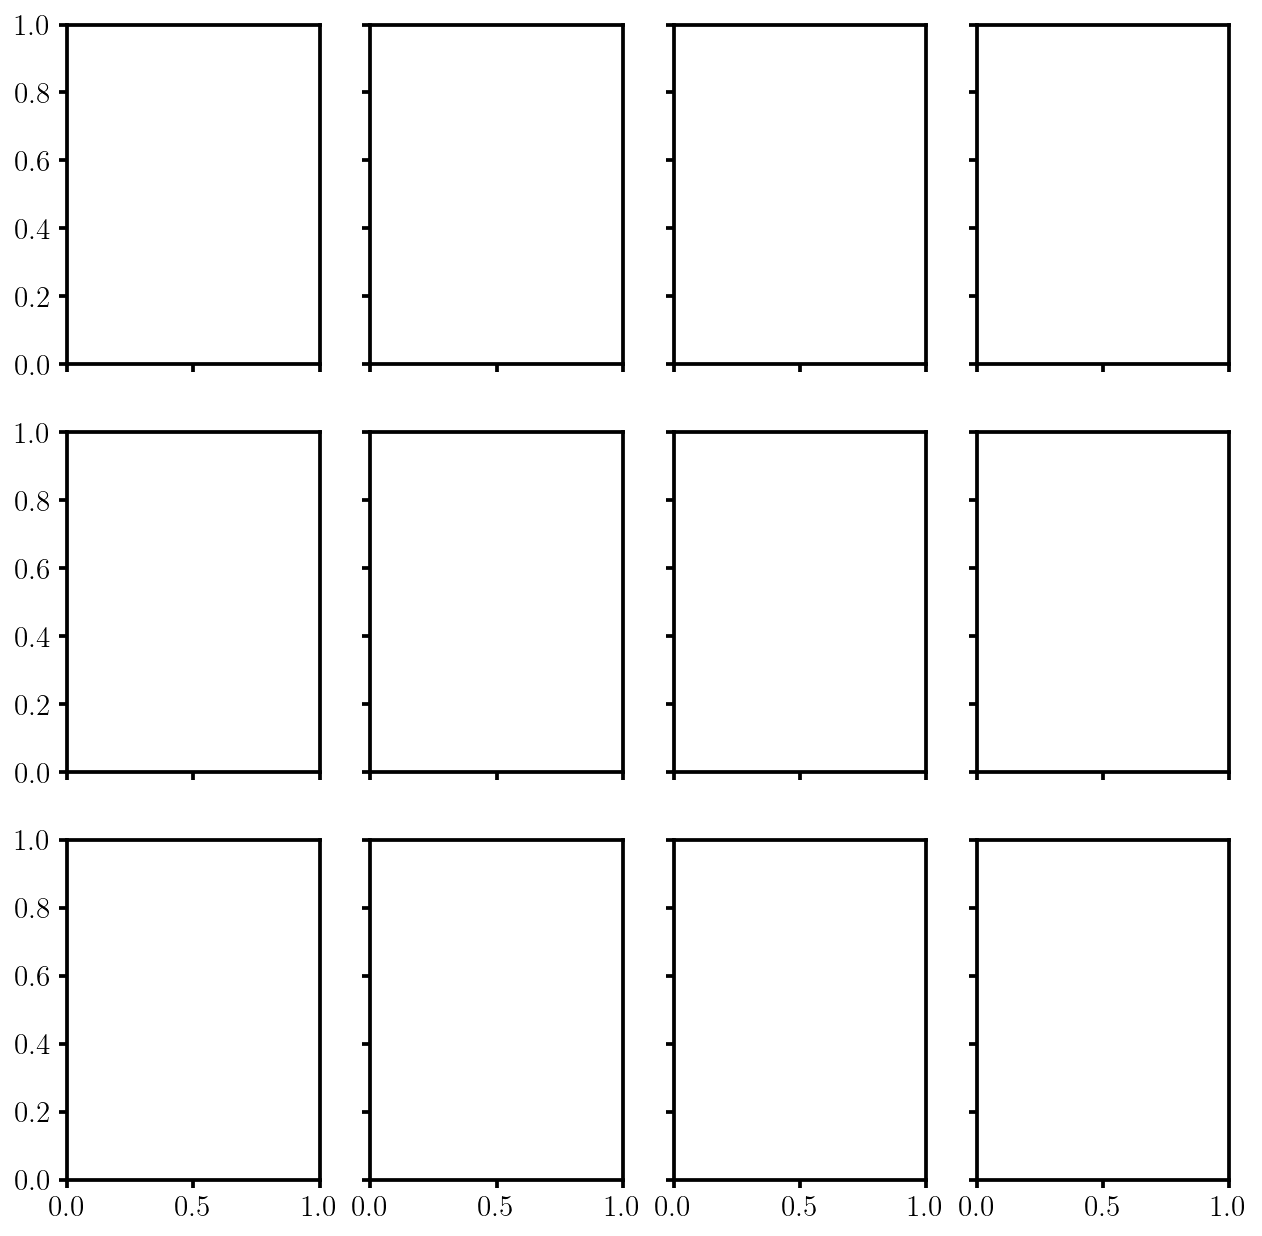

In [3]:
fig, ax = plt.subplots(3,4,dpi=150, sharex=True, sharey=True, figsize=(10, 10))

files_dir = Path('../pippin_files/snana_input/P23_variations/')

for m in model:
    wgtmap = snt.tools.read_wgtmap(files_dir / f"DES-SN5YR_LOWZ_S3_P21_{model}")

    # Beta * cint
    mu_b, sig_b = wgtmap['GENPEAK_SALT2BETA'], wgtmap['GENSIGMA_SALT2BETA'][0]
    dist_b = norm(mu_b, sig_b)
    
    mu_c, sig_c = -0.084, 0.042
    dist_c = norm(mu_c, sig_c)

# (Rv + 1) * EBV
mu_Rv = 2
sig_Rv = 1.4
min_Rv = 0.5
a_Rv = (min_Rv - mu_Rv) / sig_Rv
dist_Rv = truncnorm(a=a_Rv, b= np.inf, loc=mu_Rv, scale=sig_Rv)
tau_EBV = 0.17
dist_EBV = expon(scale=tau_EBV)

beta_salt = 3.12

N = 100000

beta =  dist_b.rvs(N)
c_int = dist_c.rvs(N)
betac = beta * c_int
Rv = dist_Rv.rvs(N)
EBV = dist_EBV.rvs(N)
RvEBV = (Rv + 1) * EBV
xth = np.linspace(-1, 1, 200)
plt.figure(figsize=(8, 6))

sns.kdeplot(betac, gridsize=300, bw_adjust=1.5, label='betac');
sns.kdeplot(RvEBV, gridsize=300, bw_adjust=1.5, label='RvEBV');
sns.kdeplot(betac+ RvEBV , gridsize=300, bw_adjust=1.5, label='tot');
sns.kdeplot(betac+ RvEBV + np.random.normal(scale=0.3, size=N), gridsize=300, bw_adjust=1.5, label='tot + noise');


plt.xlim(-1, 4)
plt.legend()
#sns.kdeplot(betac_noise, gridsize=100, bw_adjust=1.5);


In [4]:
res_model = {}
res_p21 = {}
df_BBC_ORIGIN =  {}
CIDs = {}
data_fit = defaultdict(dict)

for mock in range(8):
    print(f'Processing mock {mock:02d}')
    
    res_model[mock] = pd.read_csv(f'../results_p21_var/RES_MOCK{mock:02d}_P21_VAR_zrange_0.02_0.1_nojax.csv')
    res_model[mock].set_index('model', inplace=True)
    
    data_fit[mock] = defaultdict(dict)
    df_STDFIT = {}
    
    ###############
    # ORIGIN DATA #
    ###############

    MOCK_DIR_ORIGIN = PIPPIN_DIR / f'LSST_UCHUU_MOCK{mock:02d}_BC'
    BBC_DIR_ORIGIN = MOCK_DIR_ORIGIN / '6_BIASCOR/LSST_P21/output'
    BBC_FILE_ORIGIN = BBC_DIR_ORIGIN / f'OUTPUT_BBCFIT/FITOPT000_MUOPT000.FITRES.gz'
    
    MOCK_DIR = PIPPIN_DIR / f'LSST_UCHUU_MOCK{mock:02d}_P21_VARIATIONS_BC'
    FIT_DIR =  MOCK_DIR / '2_LCFIT'
    
    zrange = 0.02, 0.1
    
    # BBC DATA
    df_BBC_ORIGIN[mock] = ascii.read(BBC_FILE_ORIGIN).to_pandas().set_index('CIDint')
    BBC_mask = (df_BBC_ORIGIN[mock]["HOST_NMATCH"] > 0) & (df_BBC_ORIGIN[mock]['zHD'].between(zrange[0], zrange[1]))
    df_BBC_ORIGIN[mock] = df_BBC_ORIGIN[mock][BBC_mask]

    
    #####################
    # COMPUTE USED CIDs #
    #####################
    
    CIDarr = df_BBC_ORIGIN[mock].index.values
    for k in models:
        FIT_FILE = FIT_DIR /  f'LSST_FIT_LSST_{k}/output/PIP_LSST_UCHUU_MOCK{mock:02d}_P21_VARIATIONS_BC_LSST_{k}/FITOPT000.FITRES.gz'
        df_STDFIT[k] = ascii.read(FIT_FILE).to_pandas().set_index('CID')
        df_STDFIT[k][df_STDFIT[k].apply(pf.positive_def, axis=1)]
        CIDarr = np.intersect1d(CIDarr, df_STDFIT[k].index)
        
    print(f'  - PROP: {len(CIDarr) / len(df_BBC_ORIGIN[mock].index.values):.3f}')

    #######################
    # COMPUTE DATA VECTOR #
    #######################
    
    for k in models:
        # STANDARD DATA
        df_STDFIT[k] = df_STDFIT[k].loc[CIDarr]
        df_STDFIT[k] = df_STDFIT[k].apply(pf.x0_to_mB_err, axis=1)

        data_fit[mock][k] = flip.data_vector.snia_vectors.VelFromSALTfit({
            "ra": np.deg2rad(df_STDFIT[k]['HOST_RA'].values),
            "dec": np.deg2rad(df_STDFIT[k]['HOST_DEC'].values),
            "mb": df_STDFIT[k]['mB'].values ,
            "x1": df_STDFIT[k]["x1"].values,
            "c": df_STDFIT[k]["c"].values,
            "e_mb": df_STDFIT[k]["mBERR"].values,
            "e_x1": df_STDFIT[k]["x1ERR"].values,
            "e_c": df_STDFIT[k]["cERR"].values,
            "cov_mb_x1": df_STDFIT[k]["COV_mB_x1"].values,
            "cov_mb_c": df_STDFIT[k]["COV_mB_c"].values,
            "cov_x1_c": df_STDFIT[k]["COV_x1_c"].values,
            "zobs": df_STDFIT[k]["zCMB"].values,
            "rcom_zobs": cosmo.comoving_distance(df_STDFIT[k]["zCMB"].values).value * cosmo.h,
            "hubble_norm": 100 * cosmo.efunc(df_STDFIT[k]["zCMB"].values),
            "host_logmass": df_STDFIT[k]["HOST_LOGMASS"].values,
            "vtrue": df_STDFIT[k]['SIM_HOSTLIB_VPEC'].values,
            "sim_beta":  df_STDFIT[k]['SIM_beta'].values,
            "sim_c": df_STDFIT[k]['SIM_c'].values,
            "sim_rv": df_STDFIT[k]["SIM_RV"].values,
            "sim_av": df_STDFIT[k]["SIM_AV"].values,
            },                                         
            vel_estimator="full", 
            h=cosmo.h)

Processing mock 00
  - PROP: 0.963
Processing mock 01
  - PROP: 0.966
Processing mock 02
  - PROP: 0.965
Processing mock 03
  - PROP: 0.966
Processing mock 04
  - PROP: 0.968
Processing mock 05
  - PROP: 0.968
Processing mock 06
  - PROP: 0.970
Processing mock 07
  - PROP: 0.962


In [5]:
all_dv = defaultdict(list)
all_dverr = defaultdict(list)
all_dmu = defaultdict(list)
all_dmuerr = defaultdict(list)
all_c = defaultdict(list)
all_beta = defaultdict(list)
all_ebv = defaultdict(list)

for k in models:
    for m in range(8):
        par = {t: res_model[m].loc[k][t + '_STDFIT'] for t in TRIPP_KEYS}
        dmu = data_fit[m][k].compute_distance_modulus_difference(par)
        dmu_err = np.sqrt(data_fit[m][k].compute_observed_distance_modulus_variance(par))
        v, vvar = data_fit[m][k](par)
        verr = np.sqrt(vvar)
        dv = v - data_fit[m][k].data['vtrue']
        
        all_dv[k].append(dv)
        all_dverr[k].append(verr)
        all_dmu[k].append(dmu)
        all_dmuerr[k].append(dmu_err)
        all_c[k].append(data_fit[m][k].data['c'])
        all_beta[k].append(data_fit[m][k].data['sim_beta'])
        all_ebv[k].append(data_fit[m][k].data['sim_av'] / data_fit[m][k].data['sim_rv'])

In [ ]:
plt.figure()
for i in [1,2,3]:
    plt.hist(np.hstack(all_beta[f'P21_REDUCED_BETA{i}']), histtype='step', lw=2, range=[1.4, 3], bins=81)

plt.hist(np.hstack(all_beta[f'P21_FIXED_BETA']), histtype='step', lw=2, range=[1.4, 3], bins=81)


plt.figure()
plt.hist(np.hstack(all_ebv[f'P21']), histtype='step', lw=2, range=[0, 0.4], bins=81)
for i in [1,2,3]:
    plt.hist(np.hstack(all_ebv[f'P21_REDUCED_TAU{i}']), histtype='step', lw=2, range=[0, 0.4], bins=81)
plt.hist(np.hstack(all_ebv['P21_NO_DUST']), histtype='step', lw=2, range=[1.4, 3], bins=81)

plt.figure()
sk = []
sk.append(scs.skew(np.hstack(all_dmu['P21_NO_DUST'])))
for i in [1,2,3]:
    sk.append(scs.skew(np.hstack(all_dmu[f'P21_REDUCED_TAU{i}'])))
sk.append(scs.skew(np.hstack(all_dmu['P21'])))
plt.xlabel(r'$\tau / \tau_\mathrm{P21}$')
plt.ylabel('Skewness')
plt.plot([0, 0.05, 0.25, 0.75, 1], sk)


In [ ]:
xrange = [-0.4, 0.4]
plt.hist(np.hstack(all_dmu['P21']), bins=100, range=xrange)
plt.hist(np.hstack(all_dmu['P21_REDUCED_TAU3']), bins=100, range=xrange, histtype='step', lw=1.5)
plt.hist(np.hstack(all_dmu['P21_REDUCED_TAU4']), bins=100, range=xrange, histtype='step', lw=1.5)
plt.hist(np.hstack(all_dmu['P21_REDUCED_TAU2']), bins=100, range=xrange, histtype='step', lw=1.5)
plt.hist(np.hstack(all_dmu['P21_REDUCED_TAU1']), bins=100, range=xrange, histtype='step', lw=1.5)

plt.xlim(-0.3, 0.3);
plt.yscale('log')

In [ ]:
plt.figure(dpi=150)

plt.plot([-0.3, 0.3], [-0.3, 0.3], c='k', alpha=0.6)

model = 'P21'
xth = np.linspace(*xrange, 500)
quant = np.linspace(0.01, 0.99, 500)
q = np.quantile(np.hstack(all_dmu[model]), quant)
qth = np.quantile(scs.norm(scale=np.hstack(all_dmu[model]).std()).rvs(10000), quant)
plt.plot(qth, q, lw=2)

model = 'P21_NO_DUST'
xth = np.linspace(*xrange, 500)
quant = np.linspace(0.01, 0.99, 500)
q = np.quantile(np.hstack(all_dmu[model]), quant)
qth = np.quantile(scs.norm(scale=np.hstack(all_dmu[model]).std()).rvs(10000), quant)
plt.plot(qth, q, lw=1.5)


IndexError: index 4 is out of bounds for axis 0 with size 4

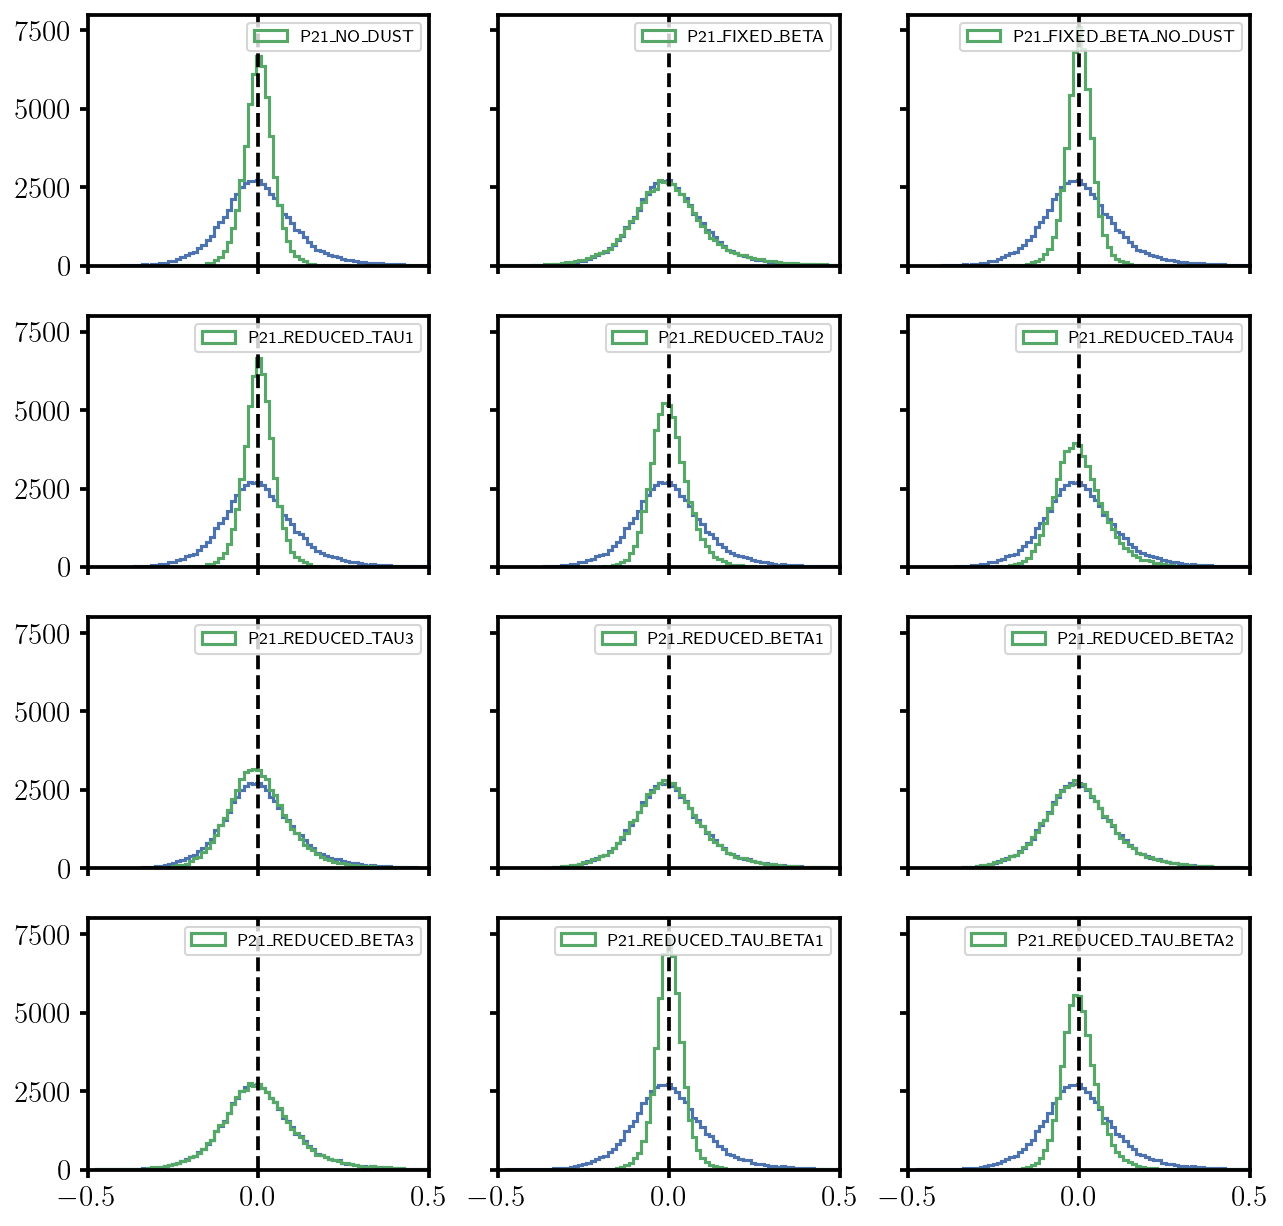

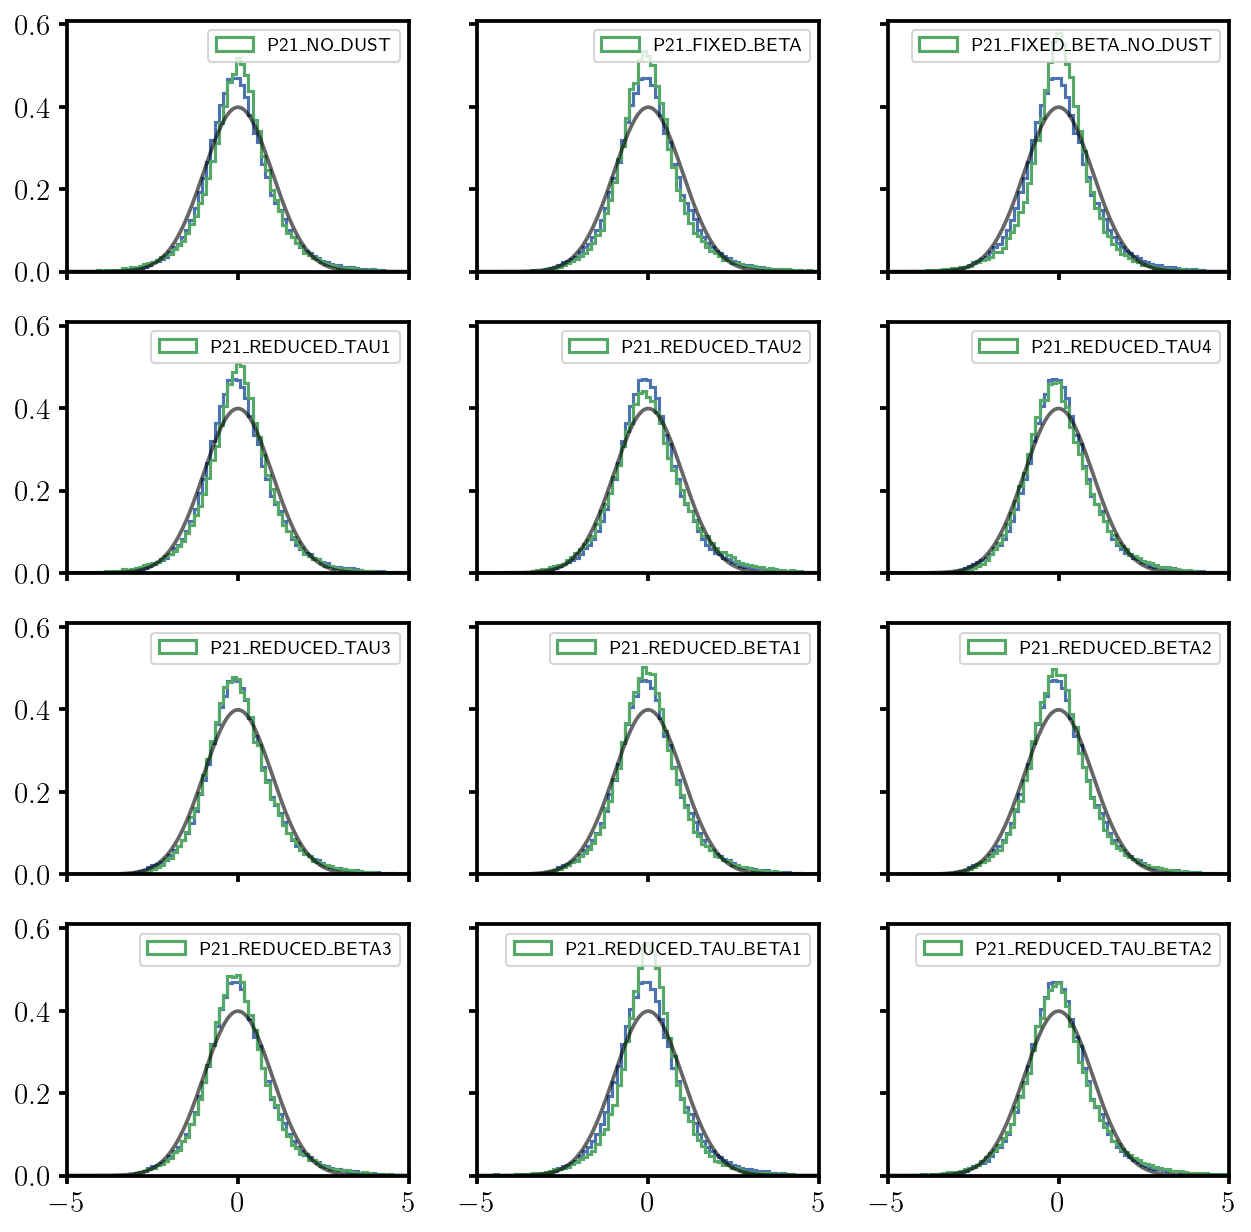

In [7]:
fig, ax = plt.subplots(4,3,dpi=150, sharex=True, sharey=True, figsize=(10, 10))
fig2, ax2 = plt.subplots(4,3,dpi=150, sharex=True, sharey=True, figsize=(10, 10))
xth = np.linspace(-5, 5, 1000)

xrange = (-0.5, 0.5)
xrange2 = (-5, 5)

nbins=81
dmu_p21 = np.hstack(all_dmu['P21'])
dmu_err_p21 = np.hstack(all_dmuerr['P21'])
i = 0
for k in models:
    if k =='P21' or k=='':
        continue
    else:
        dmu = np.hstack(all_dmu[k])
        dmu_err =  np.hstack(all_dmuerr[k])
        
        ax[i // 3, i % 3].hist(dmu_p21, range=xrange, bins=nbins, histtype='step', lw=1.5)
        ax[i // 3, i % 3].hist(dmu, range=xrange, bins=nbins, histtype='step', lw=1.5, label=k)
        ax[i // 3, i % 3].legend(loc='upper right',fontsize=8)
        ax[i // 3, i % 3].set_xlim(xrange)
        ax[i // 3, i % 3].axvline(0, c='k', ls='--')
        
        ax2[i // 3, i % 3].hist(dmu_p21 / dmu_err_p21, range=xrange2, bins=nbins, histtype='step', lw=1.5, density=True)
        #ax2[i // 3, i % 3].hist(dmu / (1.49 * np.median(np.abs(dmu))), range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)
        ax2[i // 3, i % 3].hist(dmu / dmu_err, range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)

        ax2[i // 3, i % 3].plot(xth, scs.norm().pdf(xth), c='k', alpha=0.6)
        ax2[i // 3, i % 3].set_xlim(xrange2)

        ax2[i // 3, i % 3].legend(loc='upper right',fontsize=9)
        
        #ax2[i // 3, i % 3].set_yscale('log')
        i+=1

[a.set_xlabel(r'$\Delta\mu$') for a in ax[-1, :]]
[a.set_xlabel(r'$\Delta\mu / \sigma_{\Delta\mu}$') for a in ax2[-1, :]]
fig.savefig('dmu.png')
fig.subplots_adjust(wspace=0, hspace=0)
fig2.subplots_adjust(wspace=0, hspace=0)


In [ ]:
fig, ax = plt.subplots(4,3,dpi=150, sharex=True, sharey=True, figsize=(10, 10))
fig2, ax2 = plt.subplots(4,3,dpi=150, sharex=True, sharey=True, figsize=(10, 10))
fig3, ax3 = plt.subplots(4,3, dpi=150, sharex=True, sharey=True, figsize=(10, 10))
xth = np.linspace(-5, 5, 1000)

xrange = (-2500, 2500)
xrange2 = (-5, 5)
nbins=81

n_2d_bins = 35
yrange= (-2800, 2800)
xrange3 = (-0.18, 0.2)

dv_p21 = np.hstack(all_dv['P21'])
dv_err_p21 = np.hstack(all_dverr['P21'])
all_c_p21 = np.hstack(all_c['P21'])


i = 0
for k in models:
    if k =='P21':
        continue
    else:
        dv = np.hstack(all_dv[k])
        dv_err =  np.hstack(all_dverr[k])
        ax[i // 3, i % 3].hist(dv_p21, range=xrange, bins=nbins, histtype='step', lw=1.5)
        ax[i // 3, i % 3].hist(dv, range=xrange, bins=nbins, histtype='step', lw=1.5, label=k)
        ax[i // 3, i % 3].legend(loc='upper right',fontsize=5)
        ax[i // 3, i % 3].set_xlim(xrange)
        
        ax2[i // 3, i % 3].hist(dv_p21 / dv_err_p21, range=xrange2, bins=nbins, histtype='step', lw=1.5, density=True)
        #ax2[i // 3, i % 3].hist(dmu / (1.49 * np.median(np.abs(dmu))), range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)
        ax2[i // 3, i % 3].hist(dv / np.std(dv), range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)
        ax2[i // 3, i % 3].set_xlim(xrange2)
        ax2[i // 3, i % 3].plot(xth, scs.norm().pdf(xth), c='k', alpha=0.6)
        ax2[i // 3, i % 3].legend(loc='upper right',fontsize=9)

        mut.plots.plot_density(all_c_p21, dv_p21, xrange=xrange3, yrange=yrange, 
                               bins_2d=n_2d_bins, ax=ax3[i // 3, i % 3], levels=[0.25, 0.5, 0.75], smooth=1.5, 
                               color='C0', fill=True, put_legend=False)
        
        mut.plots.plot_density(np.hstack(all_c[k]), dv, xrange=xrange3, yrange=yrange, 
                               bins_2d=n_2d_bins, ax=ax3[i // 3, i % 3], levels=[0.25, 0.5, 0.75], smooth=1.5, 
                               label=k, color='C1', fill=False, legendfs=8)
        
    
        
        i+=1
fig.subplots_adjust(wspace=0, hspace=0)
fig2.subplots_adjust(wspace=0, hspace=0)
fig3.subplots_adjust(wspace=0, hspace=0)

[a.set_xlabel('$c$') for a in ax3[-1, :]]
[a.set_ylabel(r'$\hat{v} - v_\mathrm{true}$') for a in ax3[:, 0]]

[a.set_xlabel('$$') for a in ax2[-1, :]]


P21_NO_DUST
<fs8> = 0.9155 +/- 0.0132
P21_REDUCED_TAU1
<fs8> = 0.9113 +/- 0.0154
P21_REDUCED_TAU2
<fs8> = 0.8977 +/- 0.0189
P21_REDUCED_TAU4
<fs8> = 0.8456 +/- 0.0279
P21_REDUCED_TAU3
<fs8> = 0.8201 +/- 0.0359
P21
<fs8> = 0.8055 +/- 0.038


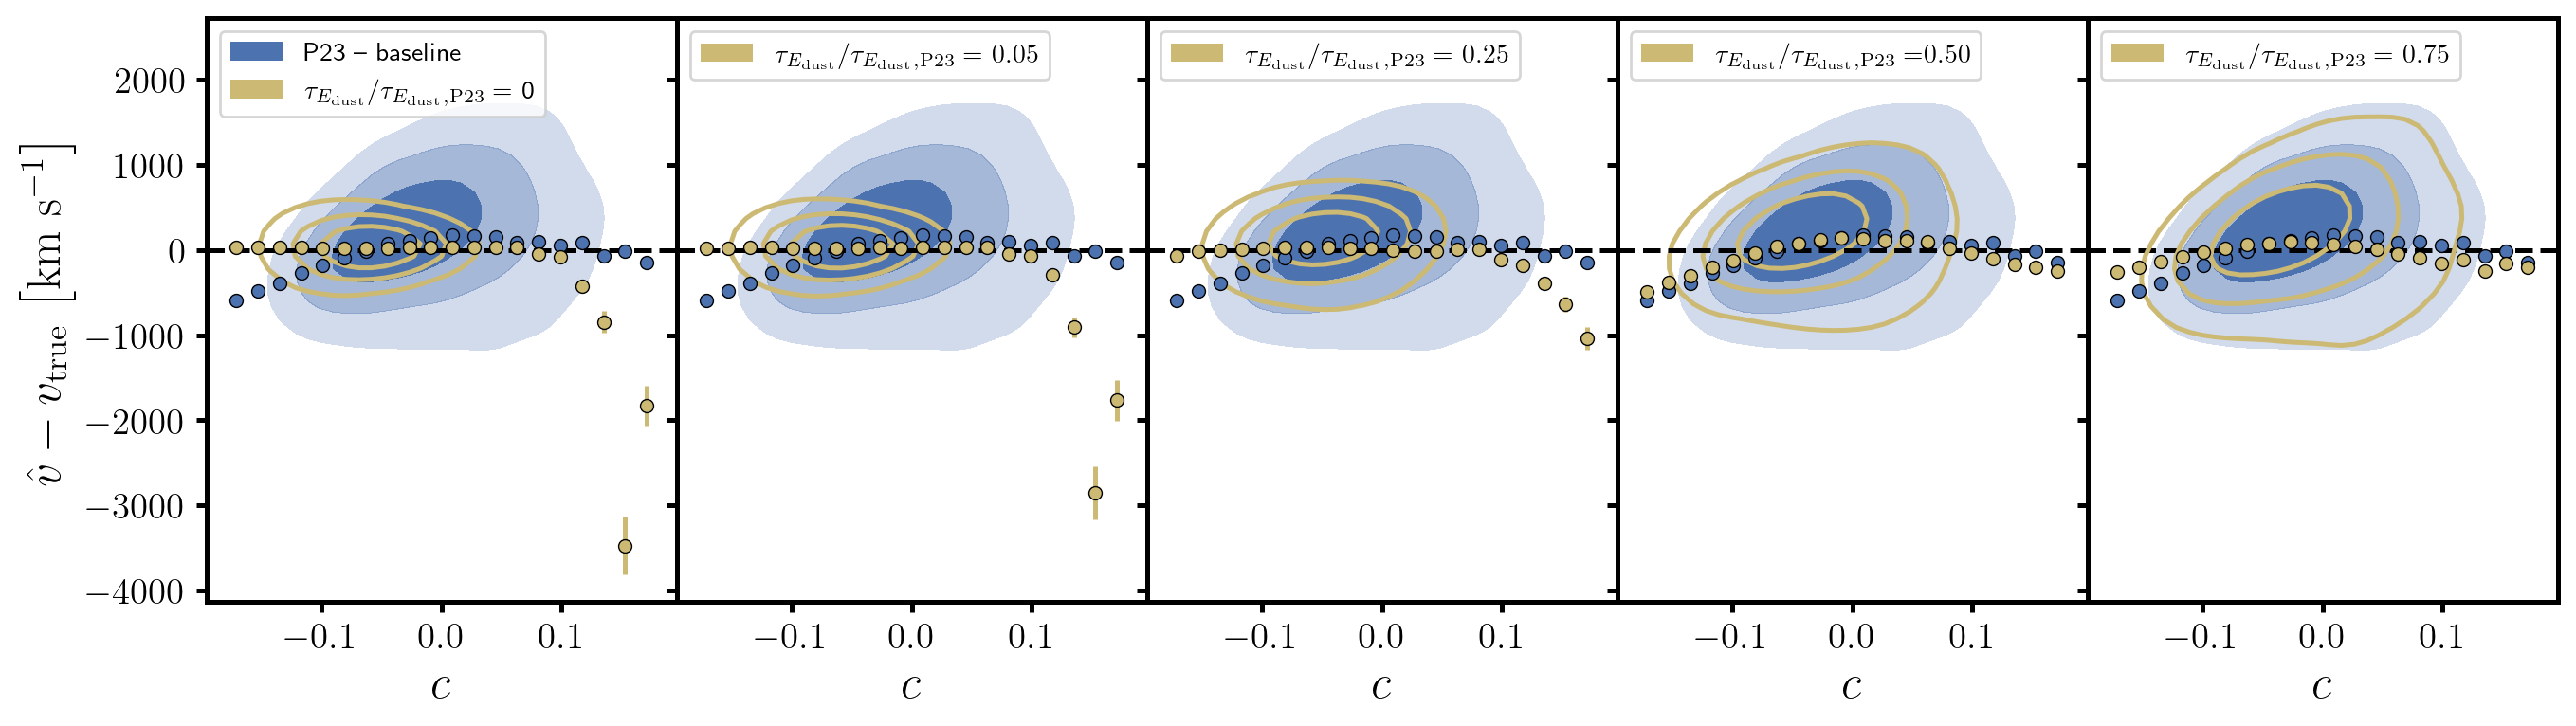

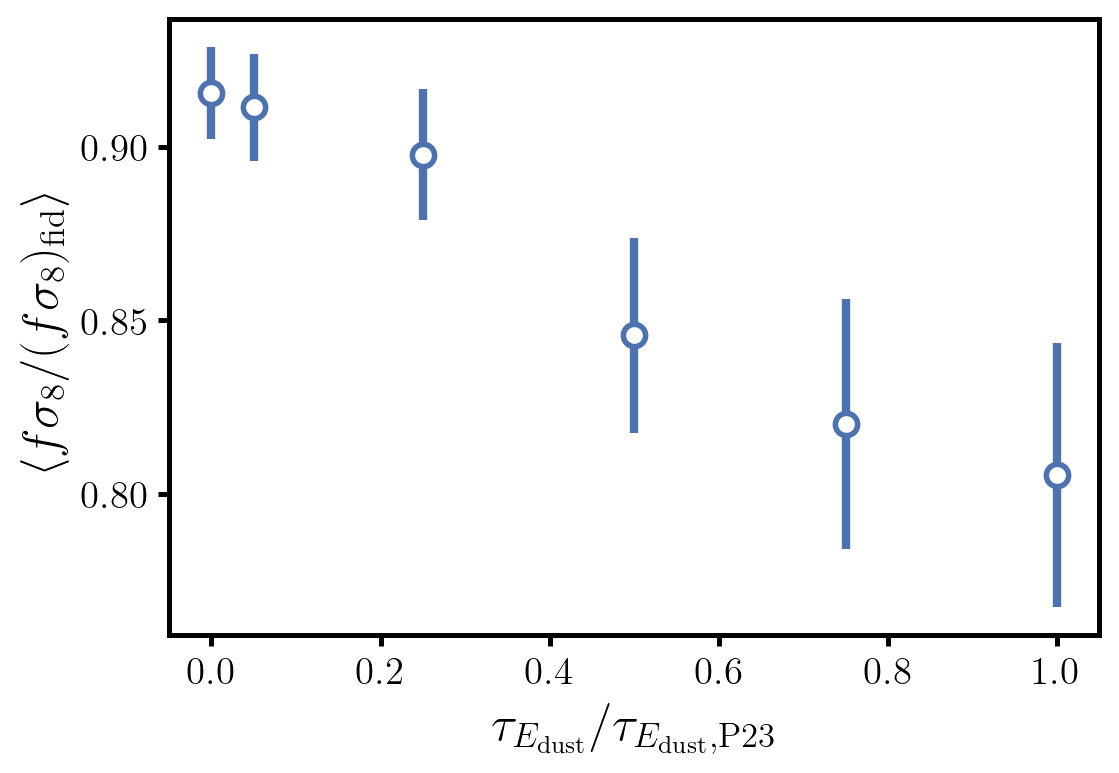

In [6]:
fig_dvc, ax_dvc = plt.subplots(1, 5, dpi=200, sharex=True, sharey=True, figsize=(16, 4))
fig_fs8, ax_fs8 = plt.subplots(1, 1, dpi=200, sharex=True, sharey=True)

n_2d_bins = 35
yrange= (-2800, 2800)
xrange3 = (-0.18, 0.18)

bins = np.linspace(xrange3[0], xrange3[1], 21)
dv_p21 = np.hstack(all_dv['P21'])
dv_err_p21 = np.hstack(all_dverr['P21'])
all_c_p21 = np.hstack(all_c['P21'])

res_fs8 = pd.concat(res_model)
df_mod = res_fs8.groupby('model')

tau_ratio = []
fs8_res = []
fs8_err = []

for j, i in enumerate([0,1,2,4,3]): 
    label =  r'$\tau_{E_\mathrm{dust}} / \tau_{E_\mathrm{dust}, \mathrm{P23}} = $'
    label_p21 = None
    put_legend=False
    if i == 0:
        k = 'P21_NO_DUST'
        label += " 0"
        tau_ratio.append(0)
        label_p21 = 'P23 -- baseline'
        put_legend=True
    else:
        k = f'P21_REDUCED_TAU{i}'

    match i:
        case 1:
            label += " $0.05$"
            tau_ratio.append(0.05)
        case 2:
            label += " $0.25$"
            tau_ratio.append(0.25)
        case 3:
            label += " $0.75$"
            tau_ratio.append(0.75)
        case 4:
            label += "$0.50$"
            tau_ratio.append(0.5)

    
    ############
    # c vs PVs #
    ############
    
    dv = np.hstack(all_dv[k])
    dverr =  np.hstack(all_dverr[k])
    c = np.hstack(all_c[k])
    mut.plots.plot_density(all_c_p21, dv_p21, xrange=xrange3, yrange=[-2500, 2500], 
                           bins_2d=n_2d_bins, ax=ax_dvc[j], levels=[0.25, 0.5, 0.75], smooth=1.5, 
                           color='C0', fill=True, put_legend=put_legend, label=label_p21, legendfs=10)
    
    x, y, yerr, _ = mut.plots.mean_in_bins(all_c_p21, dv_p21, bins, ywerr=dv_err_p21)
    ax_dvc[i].errorbar(x, y, yerr=yerr, fmt='o', color='C0', mew=0.5,mec='k', ms=5)
    
    mut.plots.plot_density(c, dv, xrange=xrange3, yrange=[-2500, 2500], 
                           bins_2d=n_2d_bins, ax=ax_dvc[j], levels=[0.25, 0.5, 0.75], smooth=1.5, 
                           label=label, color='C4', fill=False, legendfs=10)

    x, y, yerr, _ = mut.plots.mean_in_bins(c, dv, bins, ywerr=dverr)
    
    ax_dvc[i].errorbar(x, y, yerr=yerr, fmt='o', mew=0.5, mec='k', ms=5, color='C4')
        
    ax_dvc[i].axhline(0, ls='--', c='k')

    
    ####################
    # EVOLUTION OF FS8 #
    ####################

    g = df_mod.get_group(k)
    fs8_res.append(g.fs8_STDFIT.mean())
    fs8_err.append(g.fs8_STDFIT.std() / np.sqrt(8))
    print(k)
    print(f'<fs8> = {np.round(np.mean(fs8_res[-1]), 4)} +/- {np.round(np.mean(fs8_err[-1]), 4)}')


g = df_mod.get_group('P21')
fs8_res.append(g.fs8_STDFIT.mean())
fs8_err.append(g.fs8_STDFIT.std() / np.sqrt(8))
tau_ratio.append(1)
print('P21')
print(f'<fs8> = {np.round(np.mean(fs8_res[-1]), 4)} +/- {np.round(np.mean(fs8_err[-1]), 4)}')

ax_fs8.errorbar(tau_ratio, fs8_res, yerr=fs8_err, 
                fmt='o', lw=3, mew=2, mfc='w', ms=8, c='C0')
ax_fs8.set_xlabel(r'$\tau_{E_\mathrm{dust}} / \tau_{E_\mathrm{dust}, \mathrm{P23}}$') 
ax_fs8.set_ylabel(r'$\langle f\sigma_8 / (f\sigma_8)_\mathrm{fid}\rangle$') 
  
fig_dvc.subplots_adjust(wspace=0, hspace=0)
ax_dvc[0].set_ylabel(r'$\hat{v} - v_\mathrm{true}$ $\left[\mathrm{km}~\mathrm{s}^{-1}\right]$')
[a.set_xlabel('$c$') for a in ax_dvc]

fig_dvc.savefig('../Figures/vbias_tau.pdf')
fig_fs8.savefig('../Figures/fs8_tau.pdf')

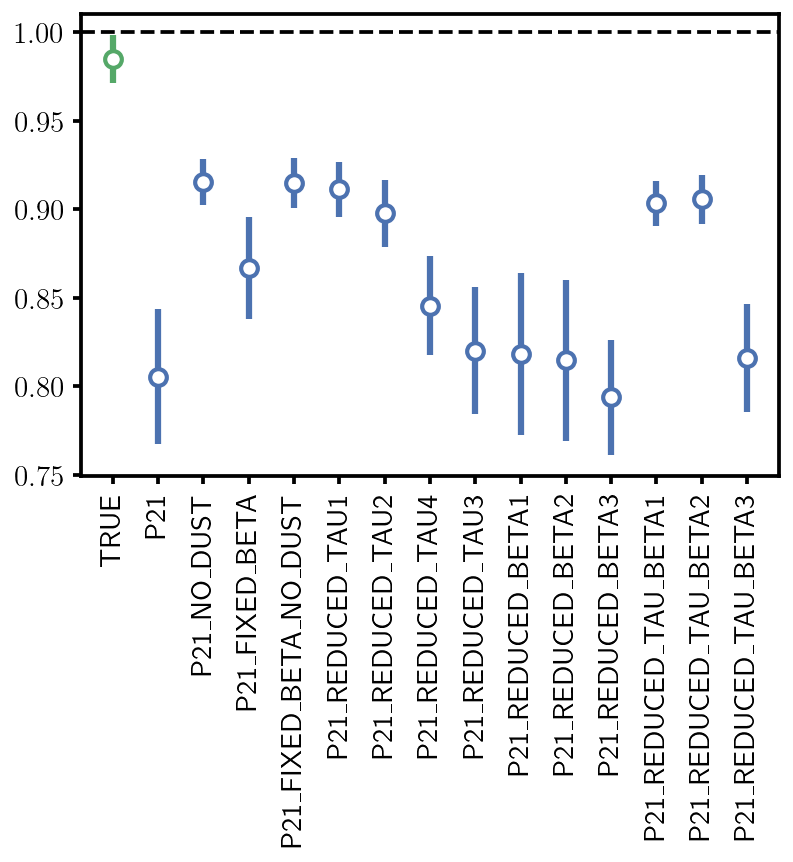

In [8]:
res_fs8 = pd.concat(res_model)
df_mod = res_fs8.groupby('model')
plt.figure(dpi=150)
for i, k in enumerate(models):
    g = df_mod.get_group(k)

    if i==0:
        MEAN_FS8_TRUE = g.fs8_TRUE.mean()
        MEAN_FS8_TRUE_ERROR = g.fs8_TRUE.std() / np.sqrt(8) 
        plt.errorbar(-1, MEAN_FS8_TRUE, yerr=MEAN_FS8_TRUE_ERROR, 
                 fmt='o', lw=3, mew=2, mfc='w', ms=8, c='C1')
        
    MEAN_FS8 = g.fs8_STDFIT.mean()
    MEAN_FS8_ERROR = g.fs8_STDFIT.std() / np.sqrt(8)
    plt.errorbar(i, MEAN_FS8, yerr=MEAN_FS8_ERROR, 
                 fmt='o', lw=3, mew=2, mfc='w', ms=8, c='C0')
plt.xticks([-1] + list(range(len(models))), labels=['TRUE'] + models);
plt.xticks(rotation=90);
plt.axhline(1, c='k', ls='--')


In [ ]:
res_fs8 = pd.concat(res_model)
df_mod = res_fs8.groupby('model')
plt.figure(dpi=150)
for i, k in :
    g = df_mod.get_group(k)

    if i==0:
        MEAN_FS8_TRUE = g.fs8_TRUE.mean()
        MEAN_FS8_TRUE_ERROR = g.fs8_TRUE.std() / np.sqrt(8) 
        plt.errorbar(-1, MEAN_FS8_TRUE, yerr=MEAN_FS8_TRUE_ERROR, 
                 fmt='o', lw=3, mew=2, mfc='w', ms=8, c='C1')
        
    MEAN_FS8 = g.fs8_STDFIT.mean()
    MEAN_FS8_ERROR = g.fs8_STDFIT.std() / np.sqrt(8)
    plt.errorbar(i, MEAN_FS8, yerr=MEAN_FS8_ERROR, 
                 fmt='o', lw=3, mew=2, mfc='w', ms=8, c='C0')
plt.xticks([-1] + list(range(len(models))), labels=['TRUE'] + models);
plt.xticks(rotation=90);
plt.axhline(1, c='k', ls='--')


In [ ]:
fig, ax = plt.subplots(3,3,dpi=150, sharex=True, sharey=True, figsize=(10, 10))
fig2, ax2 = plt.subplots(3,3,dpi=150, sharex=True, sharey=True, figsize=(10, 10))

xrange = (-4500, 4500)
xrange2 = (-5, 5)

nbins=51
v_p21, vvar_p21 = data_fit['P21']({t: resfit.loc['P21'][t + '_STDFIT'] for t in TRIPP_KEYS})
dv_p21 = v_p21 - data_fit['P21'].data['vtrue']
verr_p21 = np.sqrt(vvar_p21)
i = 0
for k in data_fit:
    if k =='P21':
        continue
    else:
        res = {t: resfit.loc[k][t + '_STDFIT'] for t in TRIPP_KEYS}
        v, vvar = data_fit[k](res)
        verr = np.sqrt(vvar)
        dv = v - data_fit[k].data['vtrue']
        
        ax[i // 3, i % 3].hist(dv_p21, range=xrange, bins=nbins, histtype='step', lw=1.5)
        ax[i // 3, i % 3].hist(dv, range=xrange, bins=nbins, histtype='step', lw=1.5, label=k)
        ax[i // 3, i % 3].legend(loc='upper right',fontsize=5)
        
        ax2[i // 3, i % 3].hist(dv_p21 / (1.48 * np.median(np.abs(dv_p21))), range=xrange2, bins=nbins, histtype='step', lw=1.5, density=True)
        ax2[i // 3, i % 3].hist(dv / (1.48 * np.median(np.abs(dv))), range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)
        ax2[i // 3, i % 3].plot(xth, scs.norm().pdf(xth), c='k', alpha=0.6)
        ax2[i // 3, i % 3].legend(loc='upper right',fontsize=5)
        ax2[i // 3, i % 3].set_yscale('log')
        i += 1
xth = np.linspace(-5, 5, 1000)


In [ ]:
fig, ax = plt.subplots(dpi=150)
fig2, ax2 = plt.subplots(dpi=150)

xrange = (-4500, 4500)
xrange2 = (-5, 5)

nbins=41

for k in data_fit:
    res = {t: resfit.loc[k][t + '_STDFIT'] for t in TRIPP_KEYS}
    v, vvar = data_fit[k](res)
    verr = np.sqrt(vvar)
    dv = v - data_fit[k].data['vtrue']
    ax.hist(dv, range=xrange, bins=nbins, histtype='step', lw=1.5, label=k)
    ax2.hist(dv / (1.48 * np.median(np.abs(dv))), range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)

    #ax2.hist(dv / verr, range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)
xth = np.linspace(-5, 5, 1000)
ax2.plot(xth, scs.norm().pdf(xth), c='k', alpha=0.6)
ax.legend()


In [ ]:
fig, ax = plt.subplots(dpi=150)

xrange = (-4500, 4500)

nbins=41

for k in data_fit:
    ax.hist(dv, range=xrange, bins=nbins, histtype='step', lw=1.5, label=k)

    #ax2.hist(dv / verr, range=xrange2, bins=nbins, histtype='step', lw=1.5, label=k, density=True)
xth = np.linspace(-5, 5, 1000)
ax2.plot(xth, scs.norm().pdf(xth), c='k', alpha=0.6)
ax.legend()

In [ ]:
zrange = [0.02, 0.1]
mock = 5
OUTPUT_DIR = '/global/homes/b/bastienc/MY_SNANA_DIR/LSST_SNANA/DESCPub00196/results_p21_var/'

######################
# SET POWER SPECTRUM #
######################

kmin = (2 * np.pi) / 2000 # 2pi / L
kmax = 0.2

kh, ptt = pf.init_PS(1e-5, kmax)

su = 21 # fitted on true vel
pw_dic_class = {'vv': [[kh, ptt * (np.sin(kh * su)/(kh * su))**2]]} 


############
# SET PATH #
############

# VARIATIONS
KEYS = [
    'P21', 
    'P21_NO_DUST', 'P21_FIXED_BETA', 'P21_FIXED_BETA_NO_DUST',
    'P21_REDUCED_TAU1','P21_REDUCED_TAU2', 'P21_REDUCED_TAU3',
    'P21_REDUCED_BETA1', 'P21_REDUCED_BETA2', 'P21_REDUCED_BETA3',
    'P21_REDUCED_TAU_BETA1', 'P21_REDUCED_TAU_BETA2', 'P21_REDUCED_TAU_BETA3'
       ]

PIPPIN_DIR = Path(os.environ['PIPPIN_OUTPUT'])
MOCK_DIR = PIPPIN_DIR / f'LSST_UCHUU_MOCK{mock:02d}_P21_VARIATIONS_BC'

FIT_DIR =  MOCK_DIR / '2_LCFIT'

# ORIGINAL
MOCK_DIR_ORIGIN = PIPPIN_DIR / f'LSST_UCHUU_MOCK{mock:02d}_BC'
BBC_DIR_ORIGIN = MOCK_DIR_ORIGIN / '6_BIASCOR/LSST_P21/output'
BBC_FILE_ORIGIN = BBC_DIR_ORIGIN / f'OUTPUT_BBCFIT/FITOPT000_MUOPT000.FITRES.gz'


#####################
# COMPUTE USED CIDs #
#####################
# BBC DATA
df_BBC_ORIGIN = ascii.read(BBC_FILE_ORIGIN).to_pandas().set_index('CIDint')
BBC_mask = (df_BBC_ORIGIN["HOST_NMATCH"] > 0) & (df_BBC_ORIGIN['zHD'].between(zrange[0], zrange[1]))
df_BBC_ORIGIN = df_BBC_ORIGIN[BBC_mask]

CIDarr = df_BBC_ORIGIN.index.values
for k in KEYS:
    FIT_FILE = FIT_DIR /  f'LSST_FIT_LSST_{k}/output/PIP_LSST_UCHUU_MOCK{mock:02d}_P21_VARIATIONS_BC_LSST_{k}/FITOPT000.FITRES.gz'
    df_STDFIT = ascii.read(FIT_FILE).to_pandas().set_index('CID')
    df_STDFIT[df_STDFIT.apply(pf.positive_def, axis=1)]
    CIDarr = np.intersect1d(CIDarr, df_STDFIT.index)

print(f'PROP: {len(CIDarr) / len(df_BBC_ORIGIN.index.values):.3f}')

del df_BBC_ORIGIN
del df_STDFIT


In [ ]:
k = 'P21_REDUCED_TAU1'

FIT_FILE = FIT_DIR /  f'LSST_FIT_LSST_{k}/output/PIP_LSST_UCHUU_MOCK{mock:02d}_P21_VARIATIONS_BC_LSST_{k}/FITOPT000.FITRES.gz'

if not FIT_FILE.exists():
    raise ValueError(f'{FIT_FILE} does not exist')
    
#############
# LOAD DATA #
#############

# STANDARD DATA
df_STDFIT = ascii.read(FIT_FILE).to_pandas().set_index('CID').loc[CIDarr]
df_STDFIT = df_STDFIT.apply(pf.x0_to_mB_err, axis=1)


# STANDARD FIT
minuit_fitter = pf.fit_fs8_stdfit(
    df_STDFIT, 
    cosmo, 
    pw_dic_class, 
    pf.parameter_dict_STDFIT, 
    pf.likelihood_properties_STDFIT,
    kmin,
    minos=False,
    hesse=False,
    n_iter=1
    )

In [ ]:
minuit_fitter.likelihood(np.array(minuit_fitter.minuit.values))